<a href="https://colab.research.google.com/github/GonzaloPerezGomez/Pytorch/blob/main/04_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

User your own data in PyTorch

## 0. Setup libraries and base code

In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## 1. Get data

Our dataset is a subset of Food101 from torchvision



In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if not image_path.is_dir():
  image_path.mkdir(parents=True, exist_ok=True)

In [3]:
# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading data...")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unziping data")
  zip_ref.extractall(image_path)

Unziping data


## 2. Becoming one with the data

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filesnames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filesnames)} images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.1 Visualizing and image

data/pizza_steak_sushi/test/sushi/479711.jpg
sushi
Random image path: data/pizza_steak_sushi/test/sushi/479711.jpg | Image class: sushi | Image height: 512 | Image width: 512


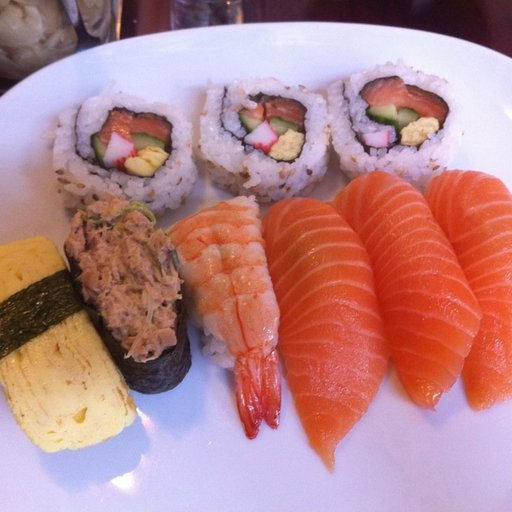

In [7]:
import random
from PIL import Image

random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path} | Image class: {image_class} | Image height: {img.height} | Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

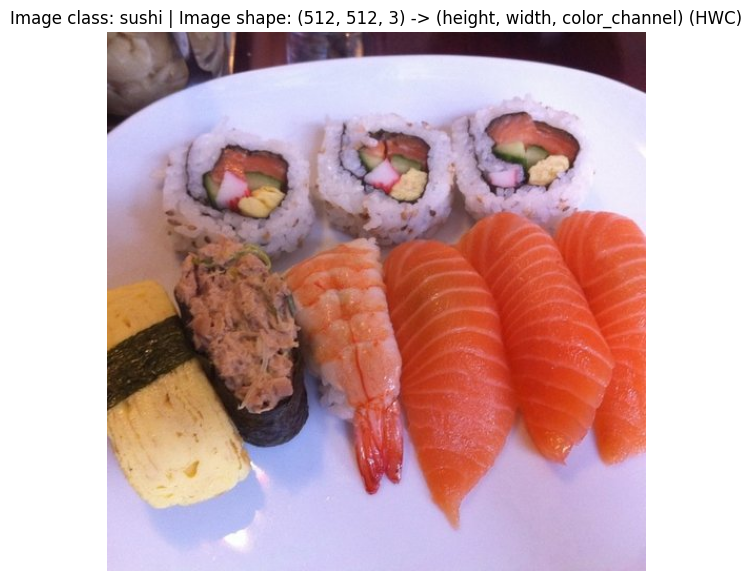

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asanyarray(img)

# Plot it
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> (height, width, color_channel) (HWC)")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Datasets` and subsenquently a `torch.utils.data.DataLoader`

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transform`

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

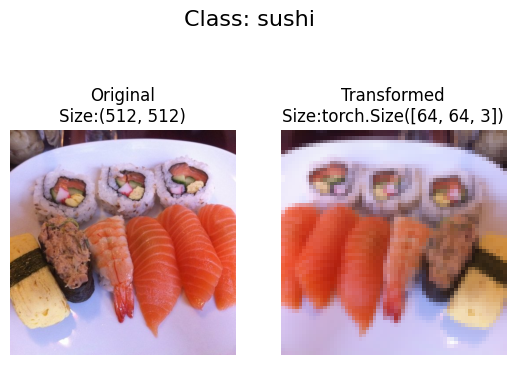

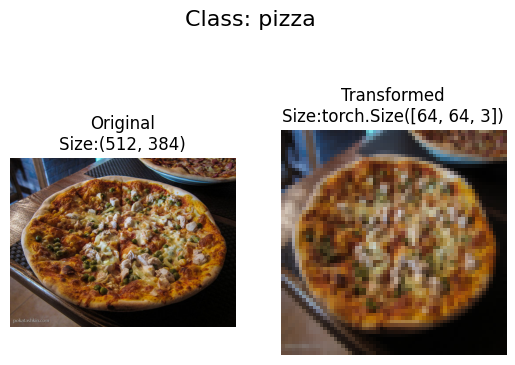

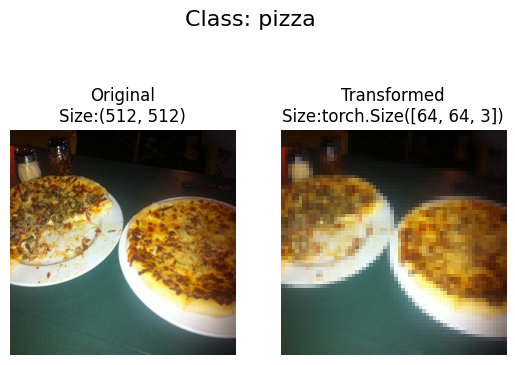

In [12]:
def plot_tranformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize:{transformed_image.size()}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_tranformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

## 4. Option 1: Loading image data using ImageFolder

In [13]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [17]:
# Index on the tran_data dataset
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor :\n {img}")
print(f"Image shape : {img.shape}")
print(f"Image dtype : {img.dtype}")
print(f"Image label : {label}")
print(f"Image label dtype : {type(label)}")

Image tensor :
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

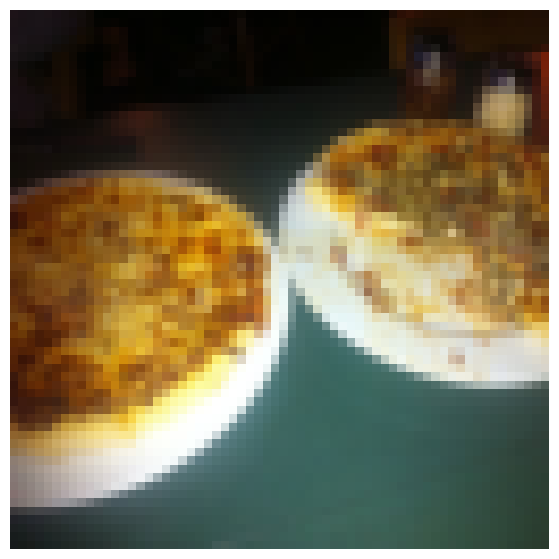

In [18]:
# Rearrange the order of dimensions
img_premute = img.permute(1, 2, 0)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_premute)
plt.axis(False)

## 4.1 Turn loaded images into `DataLoader`

In [19]:
# turn train and test datasets into Dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x783a8c25aa90>,
 <torch.utils.data.dataloader.DataLoader at 0x783a8c3a3510>)

In [20]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [21]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} | Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) | Label Shape: torch.Size([1])


## 5. Option 2: Loading image data with custom dataset

1. Be able to load images from file
2. Be able to get names from the Dataset
3. Be able to get labels as dictionary

Pros:
* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-build functions

Cons:
* It will not always work with "anything", maybe u will have to make changes
* Using a custom Dataset leads to more code, witch leads to more errors

In [22]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [23]:
train_data.classes, train_data.class_to_idx # Using torchvision.datasets.ImageFolder

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.
Let's see a small example of step 1 before we write the full function.

In [24]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [25]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [26]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder
Now we're ready to build our own custom Dataset.

We'll build one to replicate the functionality of torchvision.datasets.ImageFolder().

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom Dataset.

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:

1. Subclass torch.utils.data.Dataset.
2. Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).
3. Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).
4. Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).
5. Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
6. Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [27]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return transform data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [28]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [29]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x783a8c226dd0>,
 <__main__.ImageFolderCustom at 0x783a8c20fa50>)

In [30]:
len(train_data_custom), len(test_data_custom), len(train_data), len(test_data)

(225, 75, 225, 75)

In [31]:
train_data_custom.classes, train_data.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [32]:
train_data_custom.class_to_idx, train_data.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [33]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images
You know what time it is!

Time to put on our data explorer's hat and visualize, visualize, visualize!

Let's create a helper function called display_random_images() that helps us visualize images in our Dataset's.

Specifically, it'll:

1. Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed.
2. To prevent the display getting out of hand, we'll cap n at 10 images.
3. Set the random seed for reproducible plots (if seed is set).
4. Get a list of random sample indexes (we can use Python's random.sample() for this) to plot.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes found in step 4 and plot them with matplotlib.
7. Make sure the sample images are of shape HWC (height, width, color channels) so we can plot them.

In [34]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

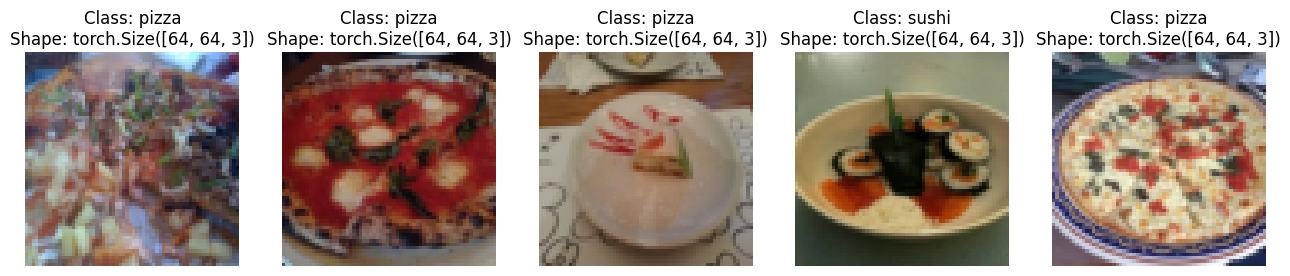

In [35]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


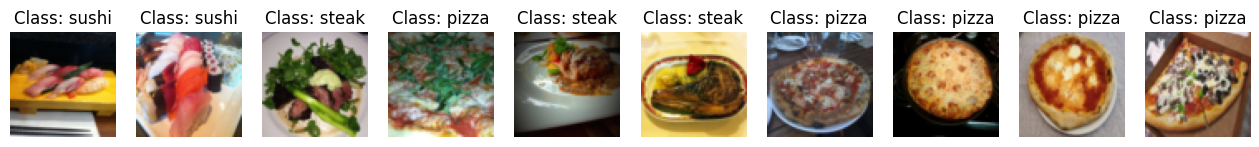

In [36]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into DataLoader's
We've got a way to turn our raw images into Dataset's (features mapped to labels or X's mapped to y's) through our ImageFolderCustom class.

Now how could we turn our custom Dataset's into DataLoader's?

If you guessed by using torch.utils.data.DataLoader(), you'd be right!

Because our custom Dataset's subclass torch.utils.data.Dataset, we can use them directly with torch.utils.data.DataLoader().

And we can do using very similar steps to before except this time we'll be using our custom created Dataset's.

In [37]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x783a89aa0d90>,
 <torch.utils.data.dataloader.DataLoader at 0x783a89a99b10>)

In [38]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).

TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models.

In [39]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

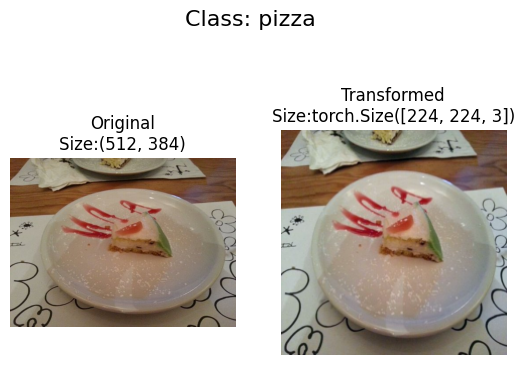

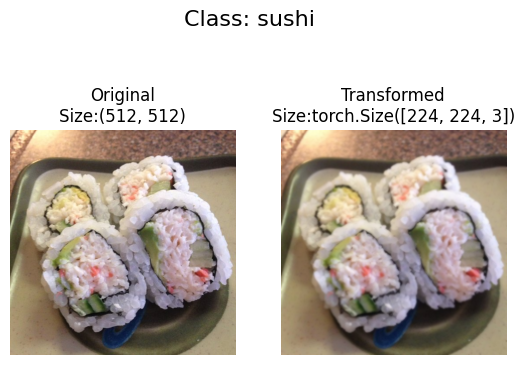

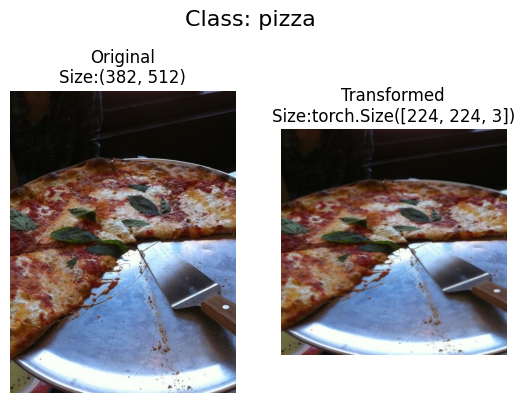

In [40]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_tranformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation
Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to (64, 64) and turning them into tensors.

### 7.1 Creating transforms and loading data for Model 0

In [41]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [42]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x783a89a69990>,
 <torch.utils.data.dataloader.DataLoader at 0x783a8dc16610>)

### 7.2 Create TinyVGG model class
In notebook 03, we used the TinyVGG model from the CNN Explainer website.

Let's recreate the same model, except this time we'll be using color images instead of grayscale (in_channels=3 instead of in_channels=1 for RGB pixels).

In [43]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)
A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the DataLoader.
2. Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target device).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax().

In [44]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0208, -0.0020,  0.0095]])

Output prediction probabilities:
tensor([[0.3371, 0.3295, 0.3333]])

Output prediction label:
tensor([0])

Actual label:
0


### 7.4 Use torchinfo to get an idea of the shapes going through our model
Printing out our model with print(model) gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the forward() method.

However, a helpful way to get information from our model is to use torchinfo.

torchinfo comes with a summary() method that takes a PyTorch model as well as an input_shape and returns what happens as a tensor moves through your model.

In [45]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train & test loop functions
We've got data and we've got a model.

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:

* train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
* test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
* train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [46]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [47]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

### 7.6 Creating a train() function to combine train_step() and test_step()
Now we need a way to put our train_step() and test_step() functions together.

To do so, we'll package them up in a train() function.

This function will train the model as well as evaluate it.

Specificially, it'll:

1. Take in a model, a DataLoader for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for train_loss, train_acc, test_loss and test_acc values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

In [48]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0

In [49]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0842 | train_acc: 0.3984 | test_loss: 1.0608 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4141 | test_loss: 1.0654 | test_acc: 0.5644
Total training time: 19.244 seconds


### 7.8 Plot the loss curves of Model 0
From the print outs of our model_0 training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's loss curves.

Loss curves show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our model_0_results dictionary.

In [50]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [51]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

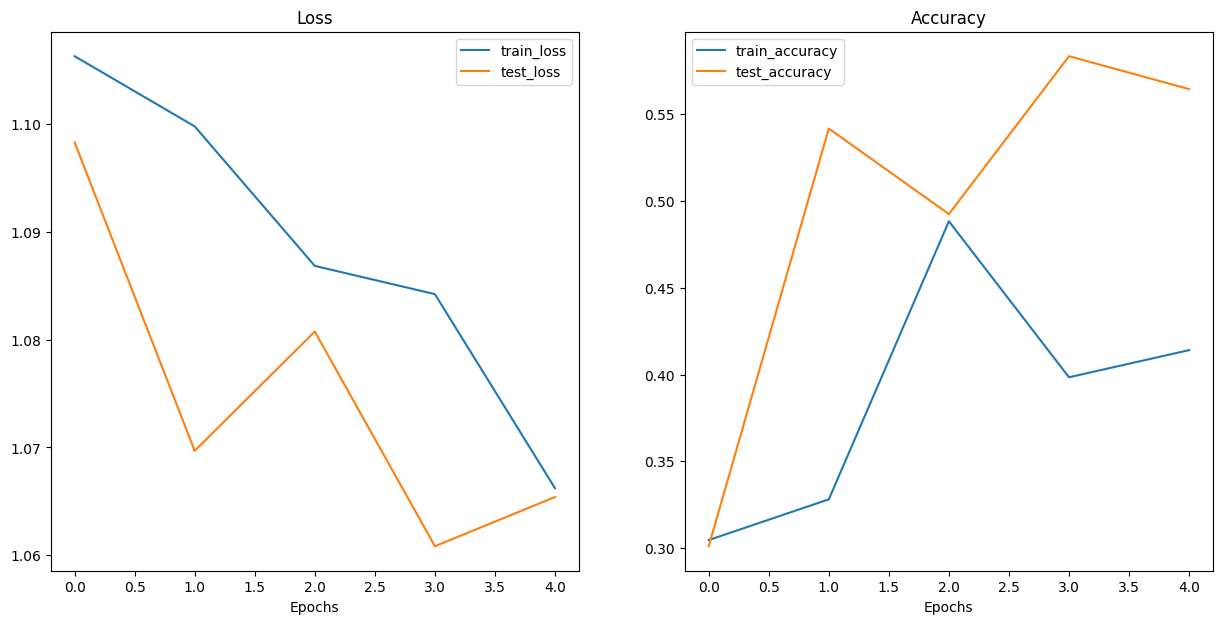

In [52]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?
Looking at training and test loss curves is a great way to see if your model is overfitting.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is overfitting.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered underfitting.

The ideal position for a training and test loss curve is for them to line up closely with each other